# IMPORT DES LIBRAIRIES

In [1]:
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import random as rd

import numpy as np
from numpy import savetxt
import pandas as pd

from datetime import datetime

import json
import gzip
import networkx as nx
import seaborn as sns
from scipy import stats
import sklearn as l
import lightgbm as lgb

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import re

from collections import defaultdict

from textblob import TextBlob
from textblob import Word

import sklearn as l
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [56]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [64]:
import csv

# IMPORT DU DATASET

In [4]:
df = pd.read_csv('comments_students.csv').sample(frac=0.2).sort_index()

In [3]:
df = df.reset_index(drop=True)

In [4]:
df.head(5)

,created_utc,ups,subreddit_id,link_id,name,subreddit,id,author,body,parent_id
0,1430438402,-5.0,t5_2qh1i,t3_34fvry,t1_cqug921,AskReddit,cqug921,youthfulvictim,I honestly wouldn't have believed it if I didn...,t1_cqug6hk
1,1430438402,1.0,t5_2qh1i,t3_34gmo3,t1_cqug929,AskReddit,cqug929,boludo54,"no money, just ID, driver license, credit card...",t3_34gmo3
2,1430438407,1.0,t5_2qh1i,t3_34c405,t1_cqug966,AskReddit,cqug966,wackawacka2,You can buy 100% MSG at stores and online. It'...,t1_cqu12b9
3,1430438408,3.0,t5_2qh1i,t3_34fkd2,t1_cqug972,AskReddit,cqug972,WarVeteranFish,Rick James and his future wife once kidnapped ...,t3_34fkd2
4,1430438409,1.0,t5_2qh1i,t3_34ffhl,t1_cqug981,AskReddit,cqug981,haggardclint,When I was a youngster until I was I was in my...,t3_34ffhl


# TRAVAUX PRELIMINAIRES

In [5]:
# df.to_csv('data_sample_20.csv')

In [3]:
df = pd.read_csv('data_sample_20.csv')

/home/salem/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### SUPRESSION DES COLONNES INUTILES 

In [9]:
# suppresion de colonnes inexploitable par notre modèle
# subreddit et subreddit id : les individus sont tous identiques ou tous différents
# author : apportera du bruit sur notre modèle si on applique une prédiction avec un author inconnu
df = df.drop(['subreddit', 'subreddit_id', 'author'], axis = 'columns')

In [36]:
# df = df.reset_index(drop=True)

In [10]:
df.head()

,created_utc,ups,link_id,name,id,body,parent_id
0,1430438402,-5.0,t3_34fvry,t1_cqug921,cqug921,I honestly wouldn't have believed it if I didn...,t1_cqug6hk
1,1430438402,1.0,t3_34gmo3,t1_cqug929,cqug929,"no money, just ID, driver license, credit card...",t3_34gmo3
2,1430438407,1.0,t3_34c405,t1_cqug966,cqug966,You can buy 100% MSG at stores and online. It'...,t1_cqu12b9
3,1430438408,3.0,t3_34fkd2,t1_cqug972,cqug972,Rick James and his future wife once kidnapped ...,t3_34fkd2
4,1430438409,1.0,t3_34ffhl,t1_cqug981,cqug981,When I was a youngster until I was I was in my...,t3_34ffhl


### NETTOYAGE DU CORPUS

In [11]:
# création du data frame rempli avec les corpus de texte
df_txt = pd.DataFrame(columns = ['corpus'])
df_txt['corpus'] = df['body']
df_txt = df_txt.astype({'corpus': str})

In [36]:
# création d'un nouveau dataframe
df_txt_clean = pd.DataFrame()

# supression de la casse
df_txt_clean['corpus'] = df_txt['corpus'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# suppresion des caractère spéciaux
df_txt_clean['corpus'] = df_txt_clean['corpus'].str.replace('[^\w\s]','')

# suppression les stops words
stop = stopwords.words('english')
df_txt_clean['corpus'] = df_txt_clean['corpus'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# suppression des mots communs (on peut changer valeur)
# n'est pas utilisé car on appliquera ce dispositif lors de la création du modèle tf-idf par exemple
"""
#freq = pd.Series(' '.join(df_txt_clean['corpus']).split()).value_counts()[:100]
#freq = list(freq.index)
#df_txt_clean['corpus'] = df_txt_clean['corpus'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
"""

# suppression des mots rares (on peut changer valeur)
# n'est pas utilisé car on appliquera ce dispositif lors de la création du modèle tf-idf par exemple
"""
freq = pd.Series(' '.join(df_txt_clean['corpus']).split()).value_counts()[-10000:]
freq = list(freq.index)
df_txt_clean['corpus'] = df_txt_clean['corpus'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
"""

# lemmatization
df_txt_clean['corpus'] = df_txt_clean['corpus'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# stemming
# n'est pas utilisé car la lemmatization est plus performant sur notre problème (elle regroupe plus de mots)
"""
st = PorterStemmer()
df_txt_clean['corpus'] = df_txt_clean['corpus'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
"""
df_txt_clean['corpus'].head()

0    honestly wouldnt believed didnt live made life...
1    money id driver license credit card subway sta...
2    buy 100 msg store online called accent flavor ...
3    rick james future wife kidnapped woman pretty ...
4    youngster teen recurring figure dream always e...
Name: corpus, dtype: object

In [ ]:
#df_txt_clean.to_csv('./txt_clean.csv', index=False)
# df_txt_clean = pd.read_csv('txt_clean.csv')
# df_txt_clean = df_txt_clean.astype({'corpus': str})

#### sauvegarde et chargement du texte nettoyé

### CREATION DU RESEAUX NETWORK

In [5]:
g = nx.DiGraph()
g.add_nodes_from(df.link_id, type = "link")
g.add_nodes_from(df.name, type = "comment")
g.add_edges_from(df[["name", "parent_id"]].values) # , link_type = "parent")


In [13]:
# nx.write_gml(g,"graph_sample_20.gml") 

In [ ]:
# g = nx.read_gml("graph.gml")

# CREATION DES FEATURES

### CREATION DE LA TABLE AVEC FEATURES 

In [14]:
g_nodes = dict(g.in_degree())

In [26]:
# Création du dataframe qui sera utilisé plus tard pour entraîner le modèle
# df_feat a une colonne 'ups' plus une colonne pour chaque feature
g_nodes = dict(g.in_degree())

# df = pd.DataFrame.from_dict(g_nodes, orient='index')
serie = pd.Series(g_nodes)
 
# sns.distplot(serie, bins = 20, kde=False) # cannot use dataframe with displot
df_feat = pd.DataFrame.from_dict(g_nodes, orient='index')
df_feat = df_feat.reset_index()

# on sélectionne uniquement les noeuds qui sont présents dans le dataset
df_feat = df_feat[df_feat['index'].isin(list(df['name']))] 
df_feat = df_feat.drop('index',axis=1)
df_feat.rename(columns={0: 'entry_nodes'}, inplace=True)
df_feat = df_feat.reset_index(drop=True)
df = df.reset_index(drop=True)
df_feat['ups'] = df['ups']
 

## Feature avec corpus

### nombre de mots

In [30]:
df_txt['word_count'] = df_txt['corpus'].apply(lambda x: len(str(x). split(" ")))
df_feat['word_count'] = list(df_txt['word_count'])
df_txt[['corpus','word_count']].head()

,corpus,word_count
0,I honestly wouldn't have believed it if I didn...,38
1,"no money, just ID, driver license, credit card...",12
2,You can buy 100% MSG at stores and online. It'...,14
3,Rick James and his future wife once kidnapped ...,25
4,When I was a youngster until I was I was in my...,494


### nombre de charactères

In [31]:
df_txt['char_count'] = df_txt['corpus'].str.len()
df_feat['char_count'] = list(df_txt['char_count'])
df_txt[['corpus', 'char_count']].head()

,corpus,char_count
0,I honestly wouldn't have believed it if I didn...,178
1,"no money, just ID, driver license, credit card...",70
2,You can buy 100% MSG at stores and online. It'...,78
3,Rick James and his future wife once kidnapped ...,192
4,When I was a youngster until I was I was in my...,2594


### longueur moyenne des mots

In [32]:
def avg_word(sentence):
    words = sentence.split()
    if len(words) == 0 :
        return 1
    else :
        return (sum(len(word) for word in words)/len(words))

df_txt['avg_word'] = df_txt['corpus'].apply(lambda x: avg_word(x))
df_feat['avg_word'] = list(df_txt['avg_word'])
df_txt[['corpus','avg_word']].head()

,corpus,avg_word
0,I honestly wouldn't have believed it if I didn...,3.710526
1,"no money, just ID, driver license, credit card...",4.916667
2,You can buy 100% MSG at stores and online. It'...,4.642857
3,Rick James and his future wife once kidnapped ...,6.720000
4,When I was a youngster until I was I was in my...,4.296524


### nombre de stop words

In [33]:
stop = stopwords.words('english')

df_txt['stopwords'] = df_txt['corpus'].apply(lambda x: len([x for x in x.split() if x in stop]))
df_feat['stopwords'] = list(df_txt['stopwords'])
df_txt[['corpus','stopwords']].head()

,corpus,stopwords
0,I honestly wouldn't have believed it if I didn...,15
1,"no money, just ID, driver license, credit card...",4
2,You can buy 100% MSG at stores and online. It'...,3
3,Rick James and his future wife once kidnapped ...,12
4,When I was a youngster until I was I was in my...,204


### nombre de charactères numérique

In [34]:
df_txt['numerics'] = df_txt['corpus'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df_feat['numerics'] = list(df_txt['numerics'])
df_txt[['corpus','numerics']].head()

,corpus,numerics
0,I honestly wouldn't have believed it if I didn...,0
1,"no money, just ID, driver license, credit card...",0
2,You can buy 100% MSG at stores and online. It'...,0
3,Rick James and his future wife once kidnapped ...,0
4,When I was a youngster until I was I was in my...,1


### nombre de mots en majuscules

In [35]:
df_txt['upper'] = df_txt['corpus'].apply(lambda x: len([x for x in x.split() if x.isupper() and x != "I"]))
df_feat['upper'] = list(df_txt['upper'])
df_txt[['corpus','upper']].head()

,corpus,upper
0,I honestly wouldn't have believed it if I didn...,0
1,"no money, just ID, driver license, credit card...",1
2,You can buy 100% MSG at stores and online. It'...,1
3,Rick James and his future wife once kidnapped ...,0
4,When I was a youngster until I was I was in my...,0


### Sentiments Analysis

In [38]:
df_txt['sentiment_polarity'] = df_txt_clean['corpus'].apply(lambda x: TextBlob(x).sentiment[0])
df_txt['sentiment_subjectivity'] = df_txt_clean['corpus'].apply(lambda x: TextBlob(x).sentiment[1])
df_txt[['sentiment_polarity', 'sentiment_subjectivity']].head()

,sentiment_polarity,sentiment_subjectivity
0,0.412121,0.800000
1,0.000000,0.000000
2,0.000000,0.000000
3,-0.060000,0.625000
4,0.009677,0.476882


In [ ]:
#df_sentiment = df_txt[['sentiment_polarity', 'sentiment_subjectivity']]
#df_sentiment.to_csv('/home/cmisid/Bureau/Scolaire/M1-S2/Projet kaggle/sentiment.csv', index=False)

#df_sentiment = pd.read_csv('/home/cmisid/Bureau/Scolaire/M1-S2/Projet kaggle/sentiment.csv')
#df_txt['sentiment_polarity'] = list(df_sentiment['sentiment_polarity'])
#df_txt['sentiment_subjectivity'] = list(df_sentiment['sentiment_subjectivity'])

In [39]:
df_feat['sentiment_polarity'] = list(df_txt['sentiment_polarity'])
df_feat['sentiment_subjectivity'] = list(df_txt['sentiment_subjectivity'])

### Word Embedding

In [57]:
# création du modèle
glove_input_file = 'glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

/home/salem/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/salem/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/salem/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrati

(400000, 50)

In [58]:
# chargement du modèle
filename = 'glove.6B.50d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

/home/salem/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [59]:
# tokenisation du corpus afin de pouvoir appliquer le modèle à nos différents mots
sentences = [word_tokenize(s) for s in df_txt_clean['corpus']]

In [60]:
# création d'un dictionnaire de mots afin d'optimiser les temps de traitement
dict_txt = {}
for i in tqdm_notebook(range(len(df_txt_clean))):
    dict_txt[str(i)] = sentences[i]

In [61]:
# get_vect
# input : un mot, le modèle
# output : retourne le vecteur du mot ou un vecteur de 0 si le mot n'est pas reconnu dans le modèle
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros(model.vector_size)

# sum_vectors
# input : une phrase, le modèle
# output : retourne la somme de vecteur pour l'ensemble de mots de la phrase
def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

In [62]:
# création d'un dictionnaire avec les différents vecteurs
dict_vec = {}
for i in tqdm_notebook(range(len(dict_txt))):
    dict_vec[str(i)] = sum_vectors(dict_txt[str(i)], model)

/home/salem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


{'0': array([  2.5216203 ,  -1.2476676 ,   2.484306  ,  -7.167058  ,
          6.3675513 ,  -1.0855871 ,  -2.3232198 ,   6.104905  ,
         -5.1275973 ,  -2.9705498 ,  -3.168909  ,  -2.4645271 ,
         -9.163872  ,  -0.51826614,   7.9059906 ,   4.155814  ,
          2.720871  ,   1.3334529 ,  -0.471331  ,  -6.0541544 ,
         -3.9424536 ,   3.6391656 ,   4.1253295 ,   4.731     ,
          3.9945598 , -20.58469   ,  -6.672475  ,   4.78791   ,
          3.422274  ,  -6.3745337 ,  33.96958   ,   2.9584248 ,
         -5.6782265 ,   1.0381058 ,  -1.5357977 ,  -0.55494   ,
          7.940409  ,   1.8548639 ,  -1.9654983 ,  -3.4901297 ,
         -0.7496472 ,  -1.6227957 ,  -5.759232  ,   6.2459383 ,
         -3.1395688 ,  -0.74843603,  -4.41656   ,  -4.7775917 ,
         -2.7443445 ,  -2.6504662 ], dtype=float32),
 '1': array([ -0.59921002,   1.13763702,   6.59068918,   0.373209  ,
          0.51579988,   1.21395802,  -4.75940037,  -0.51481003,
          2.62142491,   0.97789001,   1.0

In [70]:
DF = pd.DataFrame.from_dict(dict_vec)

In [71]:
DF.to_csv('dict_w2v.csv')

#### sauvegarde et chargement du w2v  

In [68]:
# # sauvegarde du dictionnaire
# with open('dict_w2v.csv', 'w', newline="") as csv_file:  
#     writer = csv.writer(csv_file)
#     for value in tqdm_notebook(dict_vec.values()):
#         writer.writerow(value)

Error: iterable expected, not int

In [ ]:
# convertission du dictionnaire en data frame (impossibilité de le faire directement avec panda.DataFrame.from_dic)
# w2v = DF
w2v = pd.read_csv('dict_w2v.csv', sep = ",", header = -1)

#### w2v kmeans

In [85]:
# applicatino de kmeans sur les vecteurs
kmeans = KMeans(20).fit(w2v)
df_feat['kmeans_w2v'] = kmeans.labels_

MemoryError: 

## Features avec graphs

### Degree centrality

In [6]:
degree_c = nx.degree_centrality(g)
df_deg = pd.DataFrame.from_dict(degree_c, orient='index')
df_deg = df_deg.reset_index()
df_deg = df_deg[df_deg['index'].isin(list(df['name']))]
df_feat['degree_c'] = list(df_deg[0])

### Closeness centrality

In [7]:
closeness_c = nx.closeness_centrality(g)
df_deg = pd.DataFrame.from_dict(closeness_c, orient='index')
df_deg = df_deg.reset_index()
df_deg = df_deg[df_deg['index'].isin(list(df['name']))]

In [8]:
df_feat['closeness_c'] = list(df_deg[0])

### Granularité

In [9]:
# Ici on calcule le "rang" du commentaire, i.e. 1 si c'est le premier commentaire, 2 si c'est
# un commentaire de commentaire et ainsi de suite. On ajoute 1 si on a pas le lien jusqu'au 
# noeud principal T3.
# Pour cela on utilise la fonction shortest_path_length de network qui calcule les plus petits
# chemins entre un noeud et tous les autres noeuds du réseau. On utilise ensuite le max pour 
# trouver le rang.
list_path_length = []
for i in df.index :
    name = df['name'][i]
    link_id = df['link_id'][i]
    if nx.has_path(g, name, link_id):
        list_path_length.append(max(nx.shortest_path_length(g, name).values()))
    else :
        list_path_length.append(max(nx.shortest_path_length(g, name).values())+1)
df_feat['path_length'] = list_path_length

### Laps de temps entre un commentaire et son parent

In [10]:
# On utilise un df intermédiaire où on enlève les colonnes innutiles
# On met la colonne 'name' en index, on crée un dictionnaire afin d'optimiser le temps de calcul
df_inter = df.drop(['parent_id','ups','link_id','body','id'], axis = 'columns')
df_inter = df_inter.set_index('name')
dict_name_epoch = df_inter.to_dict()['created_utc']

In [11]:
list_time_diff = []

# On parcourt la colonne 'name' du dataframe principal. On sélectionne le commentaire parent
# puis on teste si ce parent existe et si ce n'est pas un noeud 't3' car on a pas l'heure des 
# publications. Lorsqu'on a pas les informations on remplit avec np.NaN, sinon on remplit la
# différence entre le commentaire et son parent

for i in df['name']:
    parent_id = list(g.successors(i))
    if parent_id == []: 
        list_time_diff.append(np.NaN)
    elif 't3_' in parent_id[0]: #on exclut les noeuds avec 't3_' car pas dans le dataset
        list_time_diff.append(np.NaN)
    elif parent_id[0] in dict_name_epoch.keys():
        parent_time = dict_name_epoch[parent_id[0]]
        child_time = dict_name_epoch[i]
        list_time_diff.append((child_time - parent_time)/60)
    else : 
        list_time_diff.append(np.NaN)

In [12]:
df_feat['time_diff'] = list_time_diff

In [13]:
df_feat.to_csv("features_withoutKmeansLabels")

In [3]:
# df_feat = pd.read_csv("features")

## Aperçu du data frame avec les features

In [ ]:
#df_feat.to_csv('/home/cmisid/Bureau/Scolaire/M1-S2/Projet kaggle/features.csv', index=False)
#df_feat = pd.read_csv('/home/cmisid/Bureau/Scolaire/M1-S2/Projet kaggle/features.csv')

In [19]:
df_feat.drop('Unnamed: 0',axis=1, inplace = True) 

In [24]:
df_feat.head()

,entry_nodes,ups,word_count,char_count,avg_word,stopwords,numerics,upper,sentiment_polarity,sentiment_subjectivity,degree_c,closeness_c,path_length,time_diff
0,0,-5.0,38,178,3.710526,15,0,0,0.412121,0.800000,8.129956e-07,0.0,1,NaN
1,0,1.0,12,70,4.916667,4,0,1,0.000000,0.000000,8.129956e-07,0.0,1,NaN
2,1,1.0,14,78,4.642857,3,0,1,0.000000,0.000000,8.129956e-07,0.0,2,NaN
3,0,3.0,25,192,6.720000,12,0,0,-0.060000,0.625000,8.129956e-07,0.0,2,NaN
4,0,1.0,494,2594,4.296524,204,1,0,0.009677,0.476882,8.129956e-07,0.0,1,NaN


In [21]:
df_feat.columns

Index(['entry_nodes', 'ups', 'word_count', 'char_count', 'avg_word',
       'stopwords', 'numerics', 'upper', 'sentiment_polarity',
       'sentiment_subjectivity', 'degree_c', 'closeness_c', 'path_length',
       'time_diff'],
      dtype='object')

# ENTRAINEMENT DU MODELE 

### CREATION DES DATASETS

In [25]:
# séparation du jeu de validation
df_val = df_feat[df_feat['ups'].isnull() == True]
df_s = df_feat[df_feat['ups'].isnull() == False]

# séparation des jeux d'entrainement et de tests
y = df_s['ups']
X = df_s.drop('ups', axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### MODELE LGBM

In [27]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)

### PARAMETRISATION DU MODELE & ENTRAINEMENT

In [28]:
params = {
    'boosting_type': 'gbdt',
    'max_depth' : 7,
    'objective': 'regression_l1',
    'metric': 'l1',
    'num_leaves': 100,
    'learning_rate': 0.01
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 500,
                valid_sets = lgb_eval,
                early_stopping_rounds = 10)

[1]	valid_0's l1: 11.9042
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 11.8714
[3]	valid_0's l1: 11.839
[4]	valid_0's l1: 11.8071
[5]	valid_0's l1: 11.7765
[6]	valid_0's l1: 11.7414
[7]	valid_0's l1: 11.7105
[8]	valid_0's l1: 11.6769
[9]	valid_0's l1: 11.6437
[10]	valid_0's l1: 11.6158
[11]	valid_0's l1: 11.5868
[12]	valid_0's l1: 11.5556
[13]	valid_0's l1: 11.5252
[14]	valid_0's l1: 11.4954
[15]	valid_0's l1: 11.466
[16]	valid_0's l1: 11.4365
[17]	valid_0's l1: 11.4069
[18]	valid_0's l1: 11.3782
[19]	valid_0's l1: 11.3495
[20]	valid_0's l1: 11.3226
[21]	valid_0's l1: 11.2955
[22]	valid_0's l1: 11.2684
[23]	valid_0's l1: 11.2424
[24]	valid_0's l1: 11.2181
[25]	valid_0's l1: 11.1933
[26]	valid_0's l1: 11.168
[27]	valid_0's l1: 11.1443
[28]	valid_0's l1: 11.1206
[29]	valid_0's l1: 11.0984
[30]	valid_0's l1: 11.0785
[31]	valid_0's l1: 11.0593
[32]	valid_0's l1: 11.0398
[33]	valid_0's l1: 11.0203
[34]	valid_0's l1: 11.0015
[35]	valid_0's l1: 10.9846
[36]	v

[300]	valid_0's l1: 10.2375
[301]	valid_0's l1: 10.2373
[302]	valid_0's l1: 10.2371
[303]	valid_0's l1: 10.2369
[304]	valid_0's l1: 10.2366
[305]	valid_0's l1: 10.2364
[306]	valid_0's l1: 10.2363
[307]	valid_0's l1: 10.2361
[308]	valid_0's l1: 10.2355
[309]	valid_0's l1: 10.235
[310]	valid_0's l1: 10.2344
[311]	valid_0's l1: 10.2336
[312]	valid_0's l1: 10.2331
[313]	valid_0's l1: 10.2323
[314]	valid_0's l1: 10.2315
[315]	valid_0's l1: 10.2308
[316]	valid_0's l1: 10.23
[317]	valid_0's l1: 10.229
[318]	valid_0's l1: 10.2283
[319]	valid_0's l1: 10.2278
[320]	valid_0's l1: 10.2268
[321]	valid_0's l1: 10.2261
[322]	valid_0's l1: 10.2254
[323]	valid_0's l1: 10.2247
[324]	valid_0's l1: 10.2238
[325]	valid_0's l1: 10.2229
[326]	valid_0's l1: 10.222
[327]	valid_0's l1: 10.2216
[328]	valid_0's l1: 10.2208
[329]	valid_0's l1: 10.22
[330]	valid_0's l1: 10.2196
[331]	valid_0's l1: 10.2192
[332]	valid_0's l1: 10.2185
[333]	valid_0's l1: 10.2178
[334]	valid_0's l1: 10.2171
[335]	valid_0's l1: 10.2165

### IMPORTANCE DES FEATURES

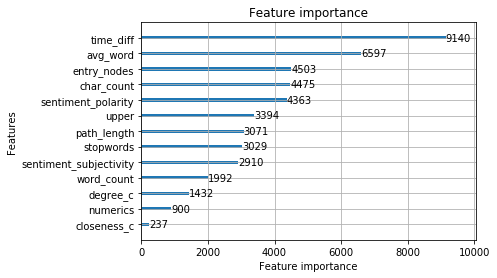

In [29]:
lgb.plot_importance(gbm)

### PREDICTION SUR LE TEST

In [30]:
y_pred = gbm.predict(X_test, num_iteration = gbm.best_iteration)
print('The mae of prediction is :', mean_absolute_error(y_test, y_pred))

The mae of prediction is : 10.16700842640855


### PREDICTION SUR LA VALIDATION

In [31]:
df_val_y = df_val['ups']
df_val_x = df_val.drop('ups',axis=1)

In [32]:
y_val = gbm.predict(df_val_x, num_iteration=gbm.best_iteration)

In [39]:
len(y_val)

203366

# Création du dataframe et exportation en .csv pour la soumission

In [59]:
aux = df[df['ups'].isnull() == True]
id_val = list(aux['id'])
df_sub = pd.DataFrame({'id':id_val[:len(y_val)],'predicted': y_val})
df_sub.to_csv('soumission.csv', index=False)


In [60]:
print(df_sub)

             id  predicted
0       crjs2zv   1.000000
1       crjs312   1.000000
2       crjs38e   1.000000
3       crjs3bp   1.000000
4       crjs3c0   1.000000
5       crjs3c4   1.000000
6       crjs3cc   1.000000
7       crjs3it   1.000000
8       crjs3o9   1.000000
9       crjs3ru   1.000000
10      crjs3so   1.000000
11      crjs3xf   1.000000
12      crjs3xh   1.000000
13      crjs3zc   1.000000
14      crjs40g   2.000074
15      crjs40r   1.000000
16      crjs40z   1.000000
17      crjs41g   1.998504
18      crjs41i   1.000000
19      crjs41m   1.000000
20      crjs42q   1.000000
21      crjs487   1.000000
22      crjs48f   1.000000
23      crjs4ba   1.000000
24      crjs4bd   1.000000
25      crjs4dq   1.000000
26      crjs4fb   1.000000
27      crjs4in   1.000000
28      crjs4iq   2.000074
29      crjs4iw   1.000000
...         ...        ...
203336  crragki   1.000000
203337  crragm3   1.000000
203338  crragnb   1.000000
203339  crragoy   1.000000
203340  crragtd   1.000000
2

# Features innutilisées pour la meilleure soumission.

### Time

In [ ]:
# création du data frame en convertissant le created_utc
df_time = pd.DataFrame(columns=['year', 'month', 'day', 'hour'])
for time in tqdm_notebook(df['created_utc']):
    this_time = datetime.utcfromtimestamp(time)
    year = this_time.strftime("%Y")
    month = this_time.strftime("%m")
    day = this_time.strftime("%d")
    hour = this_time.strftime("%H")
    df_time.loc[len(df_time)] = [year, month, day, hour]

# création de la feature hour plus rapide
df_feat['hour'] = df['created_utc'].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%H"))
df_feat['hour'] = pd.to_numeric(df_feat['hour'])

### TF-IDF & K-Means

In [ ]:
# création du tf idf
tfidf = TfidfVectorizer(max_features = 50, analyzer = 'word', ngram_range=(1,2), max_df = 0.80, min_df = 0.04)
df_txt_tfidf = tfidf.fit_transform(df_txt_clean['corpus'])

feature_names = tfidf.get_feature_names()
dense = df_txt_tfidf.todense()
denselist = dense.tolist()
tf_idf = pd.DataFrame(denselist, columns=feature_names)

# Appliquer un k-means sur notre tf-idf
kmeans = KMeans(30).fit(tf_idf)
df_feat['tfidf_kmeans'] = kmeans.labels_

### Prestige degree

In [ ]:
n_nodes = len(g_nodes)
degree_prestige = dict((v,len(g.in_edges(v))/(n_nodes-1)) for v in g.nodes())
df_prestige = pd.DataFrame.from_dict(degree_prestige, orient='index')
df_prestige = df_prestige.reset_index()
df_prestige = df_prestige[df_prestige['index'].isin(list(df['name']))]
df_feat['degree_prestige'] = list(df_prestige[0])

### Upvotes du commentaire parent

In [ ]:
# Création d'un dictionnaire pour interroger les données plus rapidement
# (évite de créer un dataframe avec .iloc() pour une recherche par condition)
# Le dictionnaire a la structure suivante : 
# {'name1' : ups1,
# 'name2' : ups2,
# ...
# }

df_inter = df.drop(['parent_id','created_utc','link_id','body'], axis = 'columns')
df_inter = df_inter.set_index('name')
dict_name_ups = df_inter.to_dict()['ups']
a = []
for i in df['name']:
    parent_id = list(g.successors(i))
    if parent_id == []: 
        a.append(np.NaN)
    elif 't3_' in parent_id[0]: #on exclut les noeuds avec 't3_' car pas dans le dataset
        a.append(np.NaN)
    elif parent_id[0] in dict_name_ups.keys():
        var = dict_name_ups[parent_id[0]]
        a.append(var)
    else : 
        a.append(np.NaN)

df_feat['parent_ups'] = a 

### Average neighbor degree

In [ ]:
dict_av_deg = nx.average_neighbor_degree(g)
df_av_ndeg = pd.DataFrame.from_dict(dict_av_deg, orient='index')
df_av_ndeg = df_av_ndeg.reset_index()
df_av_ndeg = df_av_ndeg[df_av_ndeg['index'].isin(list(df['name']))]
df_feat['average_ndeg'] = list(df_av_ndeg[0])

### Moyenne des upvotes par heure (code pas optimisé)

In [ ]:
df['created_utc'] = hour
# on sépare les commentaires et les commentaires avec un 't3_' comme parent_id
mean_per_hour = []
mean_per_hourt3 = []
df_alt_t3 = df[df['parent_id'].str.contains('t3_')]
df_alt_t1 = df[df['parent_id'].str.contains('t1_')]
for i in range (24):
    df_alt = df_alt_t1[df_alt_t1['created_utc']==i]
    df_t3 = df_alt_t3[df_alt_t3['created_utc']==i]
    mean_per_hourt3.append(np.mean(df_t3['ups']))
    mean_per_hour.append(np.mean(df_alt['ups']))
tab_mean = []
for i in range(len(df)):
    for k in range(24):
        if df['created_utc'][i] == k :
            if 't3_' in df['parent_id'][i] :
                tab_mean.append(mean_per_hourt3[k])
            else :
                tab_mean.append(mean_per_hour[k])
df_feat['mean_per_hour'] = tab_mean

# Implémentation d'une GridSearch

In [ ]:
mdl = lgb.LGBMRegressor(boosting_type= 'gbdt', 
          objective = 'regression_l1', 
          max_depth = 5,
    metric = 'l1',
    num_leaves = 31,
    learning_rate = 0.05
          )
gridParams = {
    'learning_rate': [0.001],
    'n_estimators': [100],
    'num_leaves': [31,100,250], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt'],
    'bagging_fraction' : [0.2,0.5,0.8],
    'min_data_in_leaf' : [200,600,1000]
}

grid = GridSearchCV(mdl, gridParams)
# Run the grid
grid.fit(X, y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)